# Histogram of Oriented Gradients

**Author:** Rudra Nath Palit


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

## Program to extract HoG Descriptor

### Image Differential

In [2]:
def get_differential(im):
    der_x = np.abs(cv2.Sobel(im, cv2.CV_32F, 1, 0))
    der_y = np.abs(cv2.Sobel(im, cv2.CV_32F, 0, 1))
    return (der_x, der_y)

### Calculate Gradient

In [3]:
@jit(nopython = True)
def get_gradient(der_x, der_y):
    orientation = np.degrees(np.arctan2(der_y, der_x))
    magnitude = np.sqrt(der_x**2 + der_y**2)
    return (orientation, magnitude)

### Creating HoG

In [4]:
@jit(nopython = True)
def build_histogram(orientation, magnitude, cell_size = 8, nbins = 9):
    nr = orientation.shape[0]//cell_size
    nc = orientation.shape[1]//cell_size
    delta_theta = 180/nbins
    hist = np.zeros((nr, nc, nbins))

    for i in range(0, orientation.shape[0], cell_size):
        for j in range(0, orientation.shape[1], cell_size):
            patch_orientation = orientation[i:i+cell_size, j:j+cell_size]
            patch_magnitude = magnitude[i:i+cell_size, j:j+cell_size]
            for k in range(cell_size):
                for l in range(cell_size):
                    m = patch_orientation[k,l]/delta_theta
                    bin_num1 = m//1
                    bin_num2 = (bin_num1 + 1) if bin_num1 < (nbins-1) else 0
                    bin_contri1 = 1 - (m - bin_num1)
                    bin_contri2 = 1 - bin_contri1
                    hist[i//cell_size, j//cell_size, int(bin_num1)] += bin_contri1 * patch_magnitude[k, l] 
                    hist[i//cell_size, j//cell_size, int(bin_num2)] += bin_contri2 * patch_magnitude[k, l]
    return hist

### Building the Descriptor

In [8]:
@jit(nopython = True)
def get_block_descriptor(hist, block_size = 16, cell_size = 8, nbins = 9):
    nr = int(hist.shape[0] - (block_size/cell_size) + 1)
    nc = int(hist.shape[1] - (block_size/cell_size) + 1)
    nf = int(nbins*(block_size/cell_size)**2)
    hist_norm = np.zeros((nr * nc, nf))
    count = 0
    for i in range(0, nr):
        for j in range(0, nc):
            patch = hist[i:i + int(block_size/cell_size), j:j + int(block_size/cell_size)]
            k = np.sum(patch**2)**0.5
            hist_norm[count, :] = (patch/k).reshape(1,nf)
            count += 1
    return hist_norm.reshape(nr * nc * nf)

### HoG visualization

In [271]:
def get_hog_visual(hist, img_size, cell_size = 8, bin_size = 9):
    hog_features = np.zeros((img_size[1]*10, img_size[0]*10))
    delta_theta = 180/hist.shape[2]
    theta = np.array([(i*delta_theta + delta_theta//2) for i in range(hist.shape[2])])
    theta = np.radians(theta)
    r = cell_size*5 - 10
    delta_x = np.round(r*np.cos(theta)).astype('int')
    delta_y = np.round(r*np.sin(theta)).astype('int')

    start_x = cell_size*5 - delta_x
    start_y = cell_size*5 - delta_y
    end_x   = cell_size*5 + delta_x
    end_y   = cell_size*5 + delta_y

    patch_size = cell_size*10
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            patch = np.zeros((patch_size,patch_size))
            for k in range(bin_size):
                patch = cv2.line(patch, (start_x[k], start_y[k]), (end_x[k], end_y[k]), color=int(hist[i, j, k]*255), thickness= 2)
            hog_features[i*patch_size: i*patch_size + patch_size, j*patch_size: j*patch_size + patch_size] = patch[:,:] 
            
    plt.imshow(hog_features.T, cmap='gray')
    plt.axis('off')

### Determine HoG for a given Image

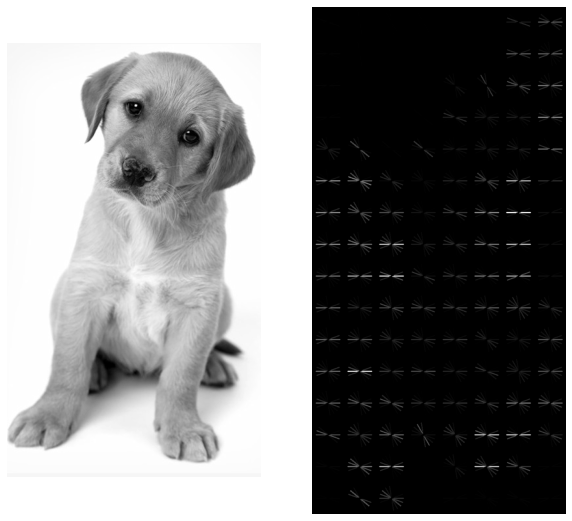

In [272]:
def extract_hog(img, img_size):
    im = cv2.resize(img , img_size).astype('float32')/255.0 
    der_x, der_y = get_differential(im)
    orientation, magnitude = get_gradient(der_x, der_y)
    hist = build_histogram(orientation, magnitude)
    hog = get_block_descriptor(hist)
    return (hog, hist)

img = cv2.imread('./image.jpeg', 0)
desc, hist = extract_hog(img, (128,64))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
get_hog_visual(hist, (128, 64))
plt.show()

## Face Recognition

### Template Matching using HoG Detector

In [275]:
def face_recognition(I_target, I_template, thereshold):
    
    # HoG Descriptor of Template
    desc_template, _ = extract_hog(I_template, (64,64))
    desc_template = desc_template/np.linalg.norm(desc_template)

    # Template matching
    nr = I_target.shape[0] - I_template.shape[0] + 1
    nc = I_target.shape[1] - I_template.shape[1] + 1
    bounding_boxes = []
    for i in range(nr):
        for j in range(nc):
            patch = I_target[i:i + I_template.shape[0], j: j + I_template.shape[1]]
            desc_patch, _ = extract_hog(patch, (64, 64))
            desc_patch = desc_patch/np.linalg.norm(desc_patch)
            score = np.dot(desc_patch, desc_template)
            if score > thereshold:
                bounding_boxes.append((i, j, score)) 
    return bounding_boxes

target = cv2.imread('target.png', 0)
template = cv2.imread('template.png', 0)

bounding_boxes = face_recognition(target, template, 0.66)


### Non-Maximum Suppression

In [276]:
def nms(bounding_boxes, template, threshold):
    dtype = [('x',int),('y', int),('score', float)]
    boxes = np.array(bounding_boxes, dtype)
    sorted = np.sort(boxes, order = 'score')
    keep = []
    while sorted.shape[0] != 0:
        keep.append(sorted[-1])
        sorted = np.delete(sorted, -1)
        l = []
        for i in range(sorted.shape[0]):
            aa = max(keep[-1][0], sorted[i]['x'])
            bb = max(keep[-1][1], sorted[i]['y'])
            xx = min(keep[-1][0], sorted[i]['x']) + template.shape[0]
            yy = min(keep[-1][1], sorted[i]['y']) + template.shape[1]

            intersection_area = max(0, xx-aa)*max(0, yy-bb)
            union_area = 2*template.shape[0]*template.shape[1] - intersection_area
            IoU = intersection_area/union_area
            if IoU > threshold:
                l.append(i)
        sorted = np.delete(sorted, l)
    return keep

keep = nms(bounding_boxes, template, 0.5)

### Draw bounding boxes

(-0.5, 239.5, 134.5, -0.5)

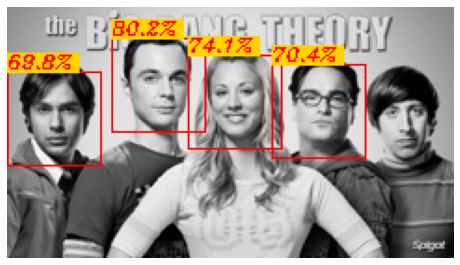

In [282]:
def draw_text(img, text, pos=(0, 0), font_scale=3, font=cv2.FONT_HERSHEY_SCRIPT_COMPLEX, font_thickness=1, text_color=(255, 0, 0), text_color_bg=(255, 211, 0)):
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    img = cv2.rectangle(img, pos, (x + text_w + 2, y + text_h + 2), text_color_bg, -1)
    img = cv2.putText(img, text, (x, y + text_h), font, font_scale, text_color, font_thickness)
    return img

result = cv2.cvtColor(target, cv2.COLOR_GRAY2BGR)

for i in keep:
    result = cv2.rectangle(result, (i[1], i[0]), (i[1] + 50, i[0] + 50), color=(255,0,0))
    result = draw_text(result, '{:.1f}%'.format(i[2]*100), (i[1], i[0] - 10), 0.35)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.axis('off')
